# Setup

In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from FittedModels.utils import plot_distributions, plot_samples, plot_sampling_info, plot_divergences, plot_history
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils.plotting_utils import plot_func2D, plot_distribution, plot_samples_single_dist
from Utils.numerical_utils import MC_estimate_true_expectation, expectation_function
from FittedModels.Models.FlowModel import FlowModel
import matplotlib.pyplot as plt

In [3]:
from TargetDistributions.base import BaseTargetDistribution

In [4]:
torch.set_default_dtype(torch.float64)

In [5]:
class Triangle_MoG(BaseTargetDistribution, nn.Module):
    # Mog with hard coded mean and cov to form a triangle
    def __init__(self, loc_scaling=5, cov_scaling=1):
        super(Triangle_MoG, self).__init__()
        dim = 2
        locs = torch.stack([torch.tensor([1.0, 0.0]), torch.tensor([0.0, 1.0]), torch.tensor([-1.0, 0.0])])*loc_scaling
        covs = torch.stack([torch.eye(dim)*cov_scaling]*3)
        self.register_buffer("locs", locs)
        self.register_buffer("covs", covs)
        self.register_buffer("cat_probs", torch.tensor([0.2, 0.6, 0.2]))

    @property
    def get_distribution(self):
        mix = torch.distributions.Categorical(self.cat_probs)
        com = torch.distributions.MultivariateNormal(self.locs, self.covs)
        return torch.distributions.MixtureSameFamily(mixture_distribution=mix, component_distribution=com)

    def log_prob(self, x):
        return self.get_distribution.log_prob(x)

    def sample(self, shape=(1,)):
        return self.get_distribution.sample(shape)

In [6]:
torch.manual_seed(0) # 0 breaks it within 1000 epochs
target = Triangle_MoG(loc_scaling=5, cov_scaling=1)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
print(true_expectation)
print(MC_estimate_true_expectation(target, expectation_function, int(1e6))) # print twice to make sure estimates are resonably close

tensor(27.0007)
tensor(27.0173)


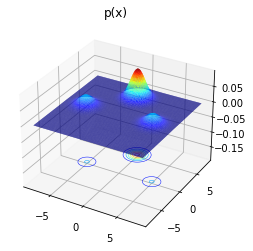

In [7]:
width = 8
fig = plot_distribution(target, bounds=[[-width, width], [-width, width]])

In [8]:
epochs = 1000
batch_size = int(1e2)
dim = 2
n_samples_estimation = int(1e6)
KPI_n_samples = int(1e6)

# DReG

In [9]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

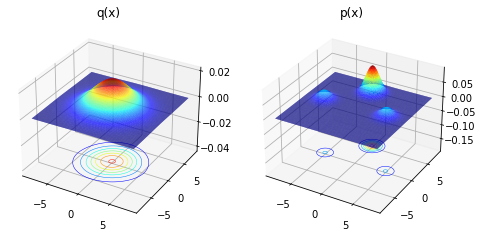

In [10]:
width = 8
fig_before_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

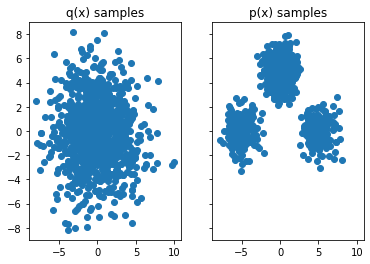

In [11]:
samples_fig_before = plot_samples(tester) 

In [ ]:
history = tester.train(epochs, batch_size=batch_size, KPI_batch_size=KPI_n_samples,
                       clip_grad=True, max_grad_norm=1)

loss: -0.8013648684436195, mean log p_x -9.895545229425274:   2%|█▌                                                                                  | 18/1000 [00:21<33:25,  2.04s/it]

In [ ]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

In [ ]:
samples_fig_after = plot_samples(tester)

In [ ]:
width = 8
fig_after_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

In [ ]:
plot_divergences(history)

In [ ]:
plot_sampling_info(history)

In [ ]:
hist_plot = plot_history(history)

# KL

In [ ]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl", lr=1e-3)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [ ]:
width = 8
fig_before_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

In [ ]:
samples_fig_before = plot_samples(tester) 

In [ ]:
history = tester.train(epochs, batch_size=batch_size, KPI_batch_size=KPI_n_samples, 
                       clip_grad=True, max_grad_norm=1)

In [ ]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

In [ ]:
samples_fig_after = plot_samples(tester)

In [ ]:
width = 8
fig_after_train = plot_distributions(tester, bounds=[[-width, width], [-width, width]])

In [ ]:
plot_divergences(history)

In [ ]:
plot_sampling_info(history)

In [ ]:
hist_plot = plot_history(history)